# General settings

In [1]:
import sys

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, bisect
import numpy as np
from numpy import linalg as nplin

In [3]:
from dcpyps import dataset
from dcpyps import dcplots
from dcpyps import dcio
from dcpyps import pdfs
from dcpyps import dcequations as dceq

# Load intervals from text file

In [4]:
def txt_load_one_col(filename):
    """"
    Read one column of data from a text file.
    """

    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    data = []
    for line in lines:
        if line != '\n':
            value = float(line.strip("\t\n"))    #divide lines into values at tabs
#            print 'value=', value
            data.append(value)

    print ("number of original intervals =", len(lines))
    print ("number of useful intervals =", len(data))
    return data

def scn_write(intervals, amplitudes, flags, calfac=1.0, ffilt=-1.0, rms=0.0,
        treso=0.0, tresg=0.0, Emem=0.0,
        filename='new_saved.SCN', type='simulated'):
    """
    Write binary SCAN (DCprogs: http://www.ucl.ac.uk/Pharmacology/dcpr95.html)
    format file.

    Parameters
    ----------
    """

    # Preapare header.
    iscanver, ioffset = -103, 154
    nint, avamp = len(intervals), np.average(amplitudes)
    title = '{0: <70}'.format(type) # char*70
    t = time.asctime()
    expdate = t[8:10] + '-' + t[4:7] + '-' + t[20:24] # '00-ooo-0000' char*11
    tapeID = '{0: <24}'.format(type) # char*24
    ipatch = 0 # integer32

    # Write header.
    fout = open(filename, 'wb')
    fout.write(struct.pack('iii', iscanver, ioffset, nint))
    fout.write(title + expdate + tapeID)
    fout.write(struct.pack('ififff', ipatch, Emem, 0, avamp, rms, ffilt))
    fout.write(struct.pack('fff', calfac, treso, tresg))

    # Write data block.
    fout.write(struct.pack('f'*nint, *intervals))
    fout.write(struct.pack('h'*nint, *amplitudes))
    fout.write(struct.pack('b'*nint, *flags))
    fout.close()

In [5]:
# LOAD DATA.
filename = "intervals1.txt"
intervals = txt_load_one_col(filename)

number of original intervals = 125
number of useful intervals = 125


In [6]:
save_to_filename = 'intervals1.scn'

# Save loaded intervals as shut intervals in scan file.
nint = 2 * len(intervals) + 1
intervals_to_save = np.ones((nint), dtype='float')
intervals_to_save[1::2] = intervals
amplitudes = np.zeros((nint), dtype='int')
amplitudes[0::2] += 1
options = np.zeros((nint), dtype='b')
dcio.scn_write(np.array(intervals_to_save), amplitudes, options,
            filename=save_to_filename, type='Converted 1 type of ints')


In [7]:
# LOAD DATA.
filename = "intervals1.scn"
filename = "/DCPYPS/dcpyps/tests/AChsim.scn"
tres = 0.0000001
tcrit = 0.0001
conc = 10000e-6
rec = dataset.SCRecord([filename], conc, tres, tcrit)
rec.printout()



 Data loaded from file: intervals1.scn
Concentration of agonist = 10000.000 microMolar
Resolution for HJC calculations = 0.1 microseconds
Critical gap length to define end of group (tcrit) = 0.100 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 250
Number of resolved periods = 250

Number of open periods = 125
Mean and SD of open periods = 1.000000047 +/- 0.000000000 ms
Range of open periods from 1.000000047 ms to 1.000000047 ms

Number of shut intervals = 125
Mean and SD of shut periods = 0.840044639 +/- 0.932190625 ms
Range of shut periods from 0.001079305 ms to 5.266318098 ms
Last shut period = 0.005504945 ms

Number of bursts = 95
Average length = 1.327109665 ms
Range: 1.000 to 16.436 millisec
Average number of openings= 1.315789474


In [8]:
#for i1, i2 in zip(intervals, np.array(rec.shint)*1000):
#    print(i1, i2)

# Stability plots

In [9]:
ma_period = 1 # Moving average interval
ma = dcplots.moving_average(intervals, ma_period) # Moving average

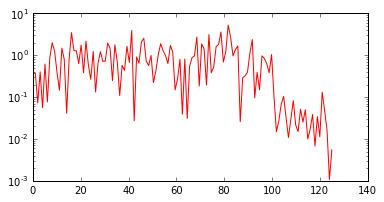

In [10]:
x = np.linspace(0, np.prod(ma.shape), num=np.prod(ma.shape), endpoint=True)
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.semilogy(x, ma, 'r', label='Open periods')

# Dwell-time histograms

Mean and SD of 125 intervals = 0.840045 +/- 0.932191
	Range from 0.00107931 to 5.26632


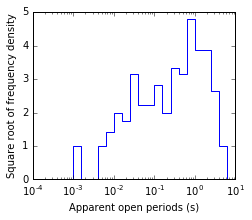

In [11]:
oxout, oyout, odx = dcplots.prepare_xlog_hist(intervals, 0.0001)
# Plot open period histogram
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121)
dcplots.xlog_hist_data(ax, intervals, 0.0001, shut=False)
print('Mean and SD of {0:d} intervals = {1:.6g} +/- {2:.6g}'.format
      (len(intervals), np.average(intervals), np.std(intervals)))
print('\tRange from {0:.6g} to {1:.6g}'.format(min(intervals),
                                                  max(intervals)))

## Fit multi-exponential pdf

##### Fit dwell time histogram

In [19]:
taus, areas = [20e-6, 1e-3], [0.8]
expPDF_sh = dceq.MultiExponentialPDF(np.asarray(rec.shint), 
                                         taus=np.asarray(taus), areas=np.asarray(areas))
print(expPDF_sh)
theta = expPDF_sh.theta
print('Start LogLikelihood =', expPDF_sh.loglik(theta))

Tau = 0.000020; lambda (1/s)= 50000.000000
Area= 0.800000; number = 104.523;amplitude (1/s) = 40000.000
Tau = 0.001000; lambda (1/s)= 1000.000000
Area= 0.200000; number = 26.131;amplitude (1/s) = 200.000

Overall mean = 0.000216
Predicted true number of events = 130
Number of fitted = 125
Number below Ylow = 5.519; number above Yhigh = 0.135

Start LogLikelihood = -679.1623110374131


In [13]:
res = minimize(expPDF_sh.loglik, theta, method='Nelder-Mead')
print(res)
expPDF_sh.theta = res.x

 final_simplex: (array([[  3.70008323e-05,   1.07296455e-03,   1.98720403e-01],
       [  3.69968155e-05,   1.07318374e-03,   1.98786914e-01],
       [  3.70126046e-05,   1.07310693e-03,   1.98733047e-01],
       [  3.69891466e-05,   1.07301561e-03,   1.98683111e-01]]), array([-776.18111542, -776.18111514, -776.18111484, -776.18111466]))
           fun: -776.18111541715029
       message: 'Optimization terminated successfully.'
          nfev: 112
           nit: 61
        status: 0
       success: True
             x: array([  3.70008323e-05,   1.07296455e-03,   1.98720403e-01])


Tau = 0.000037; lambda (1/s)= 27026.419059
Area= 0.198720; number = 25.153;amplitude (1/s) = 5370.701
Tau = 0.001073; lambda (1/s)= 931.997245
Area= 0.801280; number = 101.421;amplitude (1/s) = 746.790

Overall mean = 0.000867
Predicted true number of events = 126
Number of fitted = 125
Number below Ylow = 0.825; number above Yhigh = 0.749



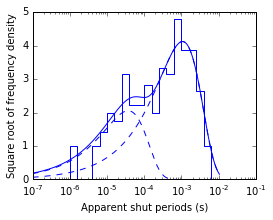

In [14]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
dcplots.xlog_hist_EXP_fit(ax, rec.tres, rec.shint, pdf=expPDF_sh.to_plot, pars=res.x, shut=True) 
print(expPDF_sh)

### Calculate approximate SD

In [15]:
def hessian(theta, LLfunc, args):
    """
    """
    hess = np.zeros((theta.size, theta.size))
    print('hessian=', hessian)
    deltas = optimal_deltas(theta, LLfunc, args)
    print('optimal deltas=', deltas)
    # Diagonal elements of Hessian
    coe11 = np.array([theta.copy(), ] * theta.size) + np.diag(deltas)
    coe33 = np.array([theta.copy(), ] * theta.size) - np.diag(deltas)
    for i in range(theta.size):
        hess[i, i] = ((LLfunc(coe11[i], args) - 
            2.0 * LLfunc(theta, args) +
            LLfunc(coe33[i], args)) / (deltas[i]  ** 2))
    # Non diagonal elements of Hessian
    for i in range(theta.size):
        for j in range(theta.size):
            coe1, coe2, coe3, coe4 = theta.copy(), theta.copy(), theta.copy(), theta.copy()
            if i != j:                
                coe1[i] += deltas[i]
                coe1[j] += deltas[j]
                coe2[i] += deltas[i]
                coe2[j] -= deltas[j]
                coe3[i] -= deltas[i]
                coe3[j] += deltas[j]
                coe4[i] -= deltas[i]
                coe4[j] -= deltas[j]
                hess[i, j] = ((
                    LLfunc(coe1, args) -
                    LLfunc(coe2, args) -
                    LLfunc(coe3, args) +
                    LLfunc(coe4, args)) /
                    (4 * deltas[i] * deltas[j]))
    return hess

def optimal_deltas(theta, LLfunc, args):
    """ """

    Lcrit = 1.005 * LLfunc(theta, args)
    print('Lcrit=', Lcrit)
    deltas = 0.1 * theta
    print('start deltas=', deltas)
    L = LLfunc(theta + deltas, args)
    if L < Lcrit:
        count = 0
        while L < Lcrit and count < 100:
            deltas *= 2
            L = LLfunc(theta + deltas, args)
            count += 1
    elif L > Lcrit:
        count = 0
        while L > Lcrit and count < 100:
            deltas *= 0.5
            L = LLfunc(theta + deltas, args)
            count += 1
    return deltas

def covariance_matrix(theta, func, args, weightmode=1):
    """ """
    cov = nplin.inv(hessian(theta, func, args))
#    if weightmode == 1:
#        errvar = SSD(theta, (func, args))[0] / (args[0].size - theta.size)
#    else:
#        errvar = 1.0
    return cov #* errvar

def correlation_matrix(covar):
    correl = np.zeros((len(covar),len(covar)))
    for i1 in range(len(covar)):
        for j1 in range(len(covar)):
            correl[i1,j1] = (covar[i1,j1] / 
                np.sqrt(np.multiply(covar[i1,i1],covar[j1,j1])))
    return correl

In [16]:
print(res.x)
print('Max log likelihood = ', res.fun)

[  3.70008323e-05   1.07296455e-03   1.98720403e-01]
Max log likelihood =  -776.181115417


In [17]:
hess = hessian(res.x, expPDF_sh.loglik, np.array(intervals))

hessian= <function hessian at 0x00000000098401E0>


TypeError: loglik() takes 2 positional arguments but 3 were given

In [ ]:
print(hess)

In [ ]:
cov = nplin.inv(hess)
print(cov)

In [ ]:
appSD = np.sqrt(cov.diagonal())
print(appSD)

In [ ]:
print(res.x)

In [ ]:
cormat = correlation_matrix(cov)

In [ ]:
print('Correlation matrix =\n', cormat)

In [ ]:
print_exps_with_errs(res.x, appSD)